### WARC 파일 활용 텍스트마이닝 연구 기법 PoC

오픈소스 WARC 처리 라이브러리인 WARCIO 모듈(https://pypi.org/project/warcio/)을 활용하여 웹기록물 데이터를 개별 웹사이트로 일일히 복원하지 않고 직접 WARC 파일을 접근하여 형태소를 추출하는 텍스트마이닝 기법을 모의 실험한다.

1. 주요 중앙행정기관 메인페이지 WARC 파일 생성
2. 형태소 추출(명사 및 용언)
3. 동시출현(Collocation) 단어 네트워크 분석
4. 문서 군집화(클러스터링, Clustering) 분석

##### 1. 주요 중앙행정기관 메인페이지 WARC 파일 생성
- 정부부처 소개 웹사이트(https://www.korea.kr/introduce/deptIntroduce.do)에 전시된 조직도상 좌측부터 5개 부서를 선택함

In [11]:
target_institution=['기획재정부', '교육부', '과기정보통신부', '외교부', '통일부']
target_urls=['http://www.moef.go.kr', 'https://www.moe.go.kr/main.do?s=moe', 'https://www.msit.go.kr/index.do', 'https://www.mofa.go.kr/www/main.do', 'https://www.unikorea.go.kr/unikorea/']

- 기관명과 웹사이트 주소를 입력하면 해당 사이트를 WARC로 변환하여 로컬에 저장
- 단, 텍스트마이닝 연구목적에 따라 전체 WARC 규격을 수집하지 않고, response 데이터만 수집함

In [12]:
from warcio.warcwriter import WARCWriter
from warcio.statusandheaders import StatusAndHeaders

import requests

# 해당 기관 메인페이지를 접속해서 WARC 파일을 생성하여 로컬에 저장하는 모듈

def generate_warc(institution, url_string):

    warc_file_path = './gov_warc_files/'
    warc_file_name = institution+'.warc.gz'
    with open(warc_file_path+warc_file_name, 'wb') as output:
        writer = WARCWriter(output, gzip=True)

        resp = requests.get(url_string,
                            headers={'Accept-Encoding': 'identity'},
                            stream=True)

        # get raw headers from urllib3
        headers_list = resp.raw.headers.items()

        http_headers = StatusAndHeaders('200 OK', headers_list, protocol='HTTP/1.0')

        record = writer.create_warc_record(url_string, 'response',
                                            payload=resp.raw,
                                            http_headers=http_headers)

        writer.write_record(record)

In [13]:
for i in range(len(target_urls)):
    generate_warc(target_institution[i], target_urls[i])

로컬에 저장된 파일 목록을 확인한다.

In [14]:
import os
os.listdir(r"./gov_warc_files/")


['과기정보통신부.warc.gz',
 '교육부.warc.gz',
 '기획재정부.warc.gz',
 '외교부.warc.gz',
 '통일부.warc.gz']

저장된 파일이 WARC 표준 포멧에 맞는지 검증을 위해 수집에 사용한 WARCIO와 다른 범용 WARC 처리 라이브러리를 통해 검증한다. 검증은 WARCAT(https://pypi.org/project/Warcat/) 라이브러리로 진행한다. WARC hearder 필드 출력으로 확인한다.

In [15]:
import warcat.model

def warc_header_fields(warc_file):
    
    filepath = "./gov_warc_files/"

    warc = warcat.model.WARC()
    warc.load(filepath + warc_file)
    record = warc.records[0]
    
    print("파일명: ", warc_file)
    print("WARC Record Header 필드값: ", record.header.fields.list())


warc_file_list = os.listdir(r"./gov_warc_files/")

for i in range(len(warc_file_list)):
    warc_header_fields(warc_file_list[i])


파일명:  과기정보통신부.warc.gz
WARC Record Header 필드값:  [('WARC-Type', 'response'), ('WARC-Record-ID', '<urn:uuid:b8833a39-269b-4a9b-b913-a632c09979a2>'), ('WARC-Target-URI', 'https://www.msit.go.kr/index.do'), ('WARC-Date', '2022-08-21T11:26:49Z'), ('WARC-Payload-Digest', 'sha1:RM52KOFUYISAZNWKYASWLQJYBQXZZJVD'), ('WARC-Block-Digest', 'sha1:QJMKXXGSLIF3LCNP6LSE3DY6OKN6JKLD'), ('Content-Type', 'application/http; msgtype=response'), ('Content-Length', '93964')]
파일명:  교육부.warc.gz
WARC Record Header 필드값:  [('WARC-Type', 'response'), ('WARC-Record-ID', '<urn:uuid:c42b4dc1-7776-4688-8e0b-df1fa1464115>'), ('WARC-Target-URI', 'https://www.moe.go.kr/main.do?s=moe'), ('WARC-Date', '2022-08-21T11:26:48Z'), ('WARC-Payload-Digest', 'sha1:37WFKBYJMLT7FUP3Q5QW7P4EE3JMYCEA'), ('WARC-Block-Digest', 'sha1:ELC63AXDPBDS2FPOFUPBQEWRJOESMBWB'), ('Content-Type', 'application/http; msgtype=response'), ('Content-Length', '828873')]
파일명:  기획재정부.warc.gz
WARC Record Header 필드값:  [('WARC-Type', 'response'), ('WARC-Record-

WARC 파일 주요 필드들인 WARC-Type, WARC-Target URI, Date 등이 올바로 출력이 되는 것으로 확인된다.

##### 2. 형태소 추출(명사 및 용언)
각 기관별 WARC 파일을 로딩하여 텍스트마이닝을 위한 전처리 및 형태소 추출 작업을 한다.

- 전처리 단계: warc 파일을 풀어서 일반 텍스트(html)로 저장한 뒤 태그 등 불필요한 문자를 제거

In [16]:
# warcio streaming

from contextlib import redirect_stdout
import requests
from warcio.archiveiterator import ArchiveIterator
import re

# 텍스트 정제 함수
# HTML 태그, 숫자, 영문 등 제거 후 각 단어들에 띄어쓰기를 한 칸씩 유지한다.
CLEANR = re.compile('[^가-힣]')
Double_space = re.compile(' +')

def cleantext(raw_html):
  cleantext = re.sub(CLEANR, ' ', raw_html)
  cleantext = cleantext.replace('\t', " ")
  cleantext = re.sub(Double_space, ' ', cleantext)
  return cleantext

# warc to text 
def warc_to_text_preprocess(warc_file):

    filepath = "./gov_warc_files/"
    text_file_name=warc_file[:-2]+""

    with open(filepath + warc_file, 'rb') as stream:
        for record in ArchiveIterator(stream):
            if record.rec_type == 'response':
                    with open('moef.html', 'w', encoding='UTF-8', ) as filedata:
                        with redirect_stdout(filedata):
                            print(record.content_stream().read().decode())


    with open('moef.html', 'r', encoding='UTF-8') as file:
        data = file.read().replace('\n', '')
        data = cleantext(data)
    
    return(data)


# 전처리된 텍스트 저장할 리스트
target_documents=[]

for i in range(len(warc_file_list)):
    a_warc_file = warc_file_list[i]
    target_documents.append(warc_to_text_preprocess(a_warc_file))

# 미리보기로 확인한다.
for i in range(len(target_documents)):
    print("원본 warc 파일:", warc_file_list[i])
    print("전처리 결과(처음 200 바이트 출력):", target_documents[i][0:200], "\n")

원본 warc 파일: 과기정보통신부.warc.gz
전처리 결과(처음 200 바이트 출력):  과학기술정보통신부 과학기술정보통신부 과기부 미래부 과학기술정보통신부 과학기술정보통신부 과학기술정보통신부 본문 바로가기 과학기술정보통신부 홈페이지 국문 메뉴이동 클릭한 메뉴 기준으로 가장 마지막 자식의 메뉴 정보를 획득하여 메뉴 이동한다 현재 메뉴가 준비중 입니다 조회중 오류가 발생 하였습니다 서브메인이동 토큰 삭제 카카오 로그아웃 완료 로그아웃 과학기술정 

원본 warc 파일: 교육부.warc.gz
전처리 결과(처음 200 바이트 출력):  국민과 함께 만드는 교육 자율 속에서 성장하는 인재 교육부 교육부 국민과 함께 만드는 교육 자율 속에서 성장하는 인재 교육부 교육부 국민과 함께 만드는 교육 자율 속에서 성장하는 인재 교육부 본문내용 바로가기 메인메뉴 바로가기 검색어를 입력해주세요 교육부 메인상단 배너 어린이 바로가기 어린이 관련누리집 교육일반 교육정보디지털도서관 교육정보디지털도서관 교육 

원본 warc 파일: 기획재정부.warc.gz
전처리 결과(처음 200 바이트 출력):  기본 정보 기획재정부 기획재정부 경제동향 지표 예산 및 기금 전자민원창구 등 수록 기획재정부 경제정책방향 세법개정안 혁신성장 현장방문 청년 일자리 최저임금 경제정책 대한민국 경제 정책과제 아카이브 한 눈에 보는 경제 한 눈에 보는 혁신성장 한국판 뉴딜 뉴딜 페이스북 카카오 공유 기획재정부 경제동향 지표 예산 및 기금 전자민원창구 등 수록 트위터 공유 기획 

원본 warc 파일: 외교부.warc.gz
전처리 결과(처음 200 바이트 출력):  외교부 외교부 외교부 여권 비자 재외공관 외교부 홈페이지에 오신것을 환영합니다 외교부 메인만 사용 메인만 사용 메인에만 출력 프린트 통합검색 검색어를 입력해주세요 스킵내비게이션 바로가기 메뉴 본문 바로가기 주메뉴 바로가기 스킵내비게이션 헤더 새창으로 어린이 청소년 새창으로 국립외교원 새창에서 열림 대통령실 새창으로 외교부 새창열림 정부혁신 보다나은 

이외에 참고로, 경찰청과 고용노동부도 수집을 해보았으나 결과가 없었다. 본 PoC 는 수집기 보다는 warc 파일을 활용한 텍스트마이닝 테스트에 목적이 있으므로, 일단 무시하고 위에 선정된 5개 warc 파일을 대상으로 진행한다. 

- 한글 형태소 추출(명사 및 용언)

In [17]:
# Kkma 활용
from konlpy.tag import Kkma
kkma = Kkma()

# 명사 동사 추출 함수
def NounAndVerb(text):
    text_str = str(text)
    morph_list = kkma.pos(text_str)
    
    # Okt
    #result = list(filter(lambda x: x[1] == "Noun" or x[1] == "Verb", morph_list))
    
    # Kkma 태그: NNG 일반명사, NNP 고유명사, VV 동사, VA 형용사
    # 
    result = list(filter(lambda x: x[1] == "NNG" or x[1] == "NNP" or x[1] == "VV" or x[1] == "VA", morph_list))
    morphed_txt=""
    for item in result:
        if len(item[0])==1:
            continue
        elif item[1] == "VV" or item[1] == "VA" or item[1] == "VV":
            morphed_txt += " " + item[0] +"다"
        else:
            morphed_txt += " " + item[0]

    return(morphed_txt)


In [18]:
# 형태소 추출값 저장소
NounsAndVerbs = []

# 경찰청, 고용노동부를 index에서 제외하고 나머지 3개만 처리한다.
for i in range(len(target_documents)):
    NounsAndVerbs.append(NounAndVerb(target_documents[i]))

수집된 형태소 데이터의 문서내 빈도수(frequence)를 기준으로 워드클라우드를 그린다.

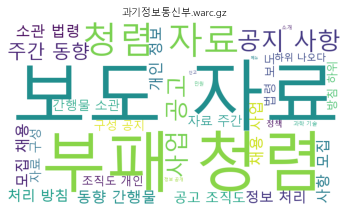

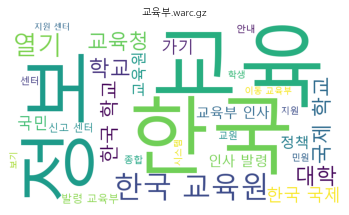

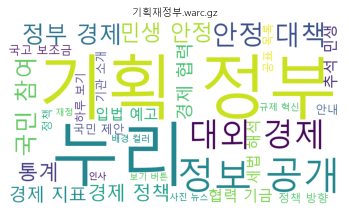

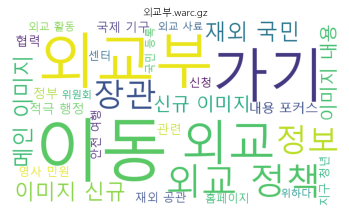

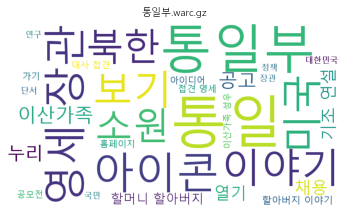

In [23]:
import wordcloud
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 관련 설정
path = 'C:\Windows\Fonts\malgunsl.ttf'
fontprop = fm.FontProperties(fname=path)
stopwords=['새창', '열림', '열리다']
for i in range(len(NounsAndVerbs)):
    cloud = wordcloud.WordCloud(stopwords=stopwords, max_words=30, width=900, height=500, background_color="white", font_path='C:\Windows\Fonts\malgun.ttf').generate(NounsAndVerbs[i])
    plt.imshow(cloud)
    plt.axis('off')
    plot_title = warc_file_list[i]
    plt.title(plot_title, fontproperties=fontprop)
    #file_name = '.\charts\{소단원}_C{cluster}.png'.format(소단원=work, cluster=cluster_num)
    # plt.savefig(file_name)
    # plt.clf()
    plt.show()

권영세 장관 등 사전에 없는 인명 등의 고유명사는 별도의 용어처리 및 사전구축을 통해 해결해야 하지만, 이는 별도의 공수가 많이 필요하므로 PoC 단계에서는 일단 skip한다.

단어 빈도수 기반의 warc 파일 분석으로 기관별 특성을 어느정도 확인할 수 있다.

##### 3. 동시출현어휘(Collocation) 분석

단어 빈도수에 기반한 텍스트마이닝은 단어들의 등장 순서를 고려하지 않는다. 연어(Collocation) 처리는 Bigram(연속해서 사용되는 2개 단어) 및 N-Gram(연속해서 사용되는 n개 단어) 등으로 확대될 수 있으나, 별도의 모델이 필요하다.

본 PoC 에서는 동시 출현 빈도수를 분석하는 Bigram 분석 및 그 결과를 네트워크 그래프로 표현하여 어떤 단어들이 서로 연관되서 표현되는지 확인한다.

동시출현 빈도 상위 20개 어휘세트를 기준으로 분석한다.

In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import nltk
from nltk import bigrams
from nltk.corpus import stopwords
import re
import networkx as nx

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

- 토큰화

In [26]:
tokens = []
for i in range(len(NounsAndVerbs)):
    tokens.append(nltk.word_tokenize(NounsAndVerbs[i]))

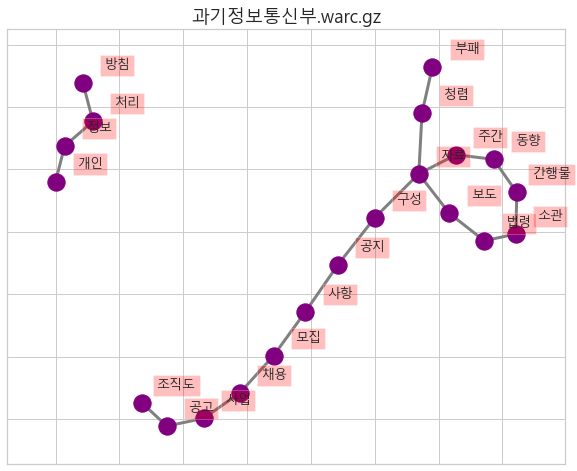

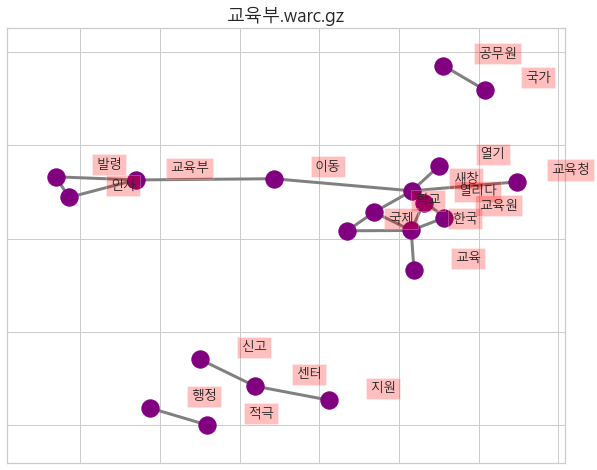

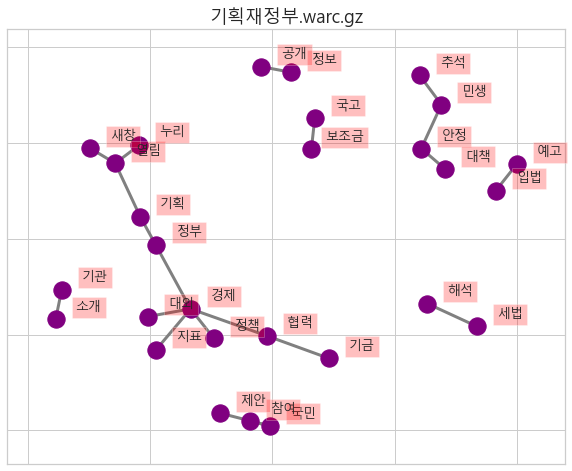

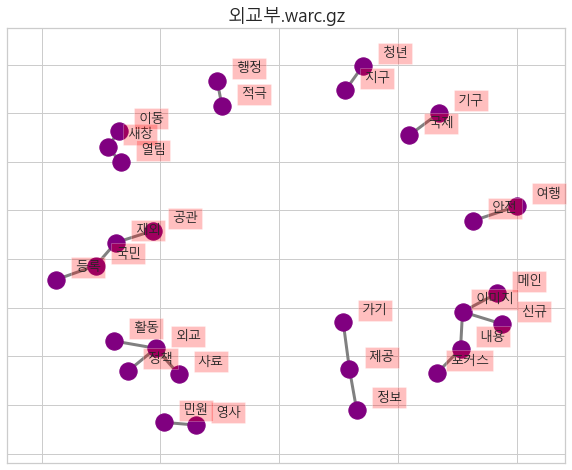

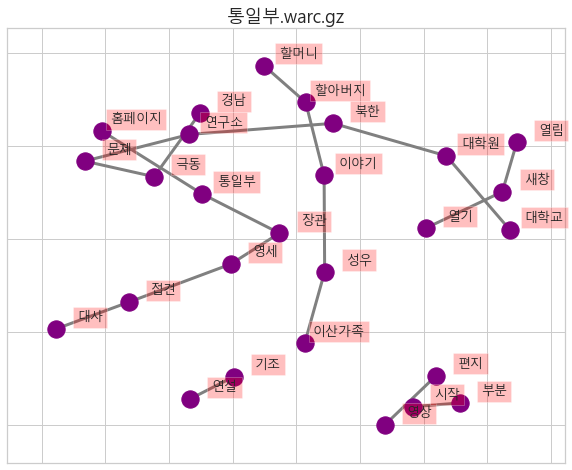

In [27]:
import matplotlib.font_manager as fm 
from matplotlib import rc
font_name = fm.FontProperties(fname='C:\Windows\Fonts\malgun.ttf').get_name()
rc('font', family=font_name)

def collocation_network(tokens):

    terms_bigram = list(nltk.bigrams(tokens))

    bigrams = list(itertools.chain(terms_bigram))

    bigram_counts = collections.Counter(bigrams)

    bigram_df = pd.DataFrame(bigram_counts.most_common(20), columns=['bigram', 'count'])


    d = bigram_df.set_index('bigram').T.to_dict('records')
    # Create network plot 
    G = nx.Graph()

    # Create connections between nodes
    for k, v in d[0].items():
        G.add_edge(k[0], k[1], weight=(v * 10))

    fig, ax = plt.subplots(figsize=(10, 8))

    plt.title(warc_file_list[i])

    pos = nx.spring_layout(G, k=2)

    # Plot networks
    nx.draw_networkx(G, pos,
                    font_size=16,
                    width=3,
                    edge_color='grey',
                    node_color='purple',
                    with_labels = False,
                    ax=ax, font_family=font_name)

    # Create offset labels
    for key, value in pos.items():
        x, y = value[0]+.135, value[1]+.045
        ax.text(x, y,
                s=key,
                bbox=dict(facecolor='red', alpha=0.25),
                horizontalalignment='center', fontsize=13)
        
    plt.show()

for i in range(len(tokens)):
    collocation_network(tokens[i])

관찰
- 이동, 새창, 열림 등 기능적 단어들의 네트워크와 각 부처의 업무 내용관련 어휘들의 네트워크가 분리되는 경향이 보인다. 웹사이트 IA(정보구조)에 관한 분석이라면 기능적 어휘들도 중요할 수 있지만, 부처들의 업무에만 집중한다면, 해당 어휘들을 추가로 정제할 수 있다.
- 외교부는 어휘 네트워크가 파편화된 반면, 통일부는 많은 단어들이 서로 연결되어 있다.
- 과기부의 경우 업무를 알 수 있는 어휘들이 거의 없고, 매우 일반적인 사무적 어휘들이 지배적이다.


#### 소결
- WARC 파일을 웹사이트로 복원할 필요없이 다수의 WARC 파일에 직접 접근하는 텍스트마이닝 연구가 가능하다.
- 해당 연구는 범용 오픈소스 파이썬 라이브러리를 활용할 수 있어 편의성이 높다(단, WARC 파일이 제공되야함)
- 웹사이트에 UTF-8 표준에 벗어나는 한글 인코딩 문제가 있을 경우, 이를 우회할 수 있는 예외처리 코딩이 필요하다.(위 결과는 몇번의 시행착으를 통해 한글 인코딩 문제를 우회한 상태임) 